In [1]:
from datetime import datetime
from langchain.adapters.openai import convert_openai_messages
from langchain_openai import ChatOpenAI
from langgraph.graph import END, Graph,MessageGraph

In [2]:
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Now you can use the environment variables
import os
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY_L')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY_L')


In [3]:
open_ai_model = 'gpt-4o'

In [5]:
from typing import TypedDict, Annotated, Sequence, Dict,Union,Any,List
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    # The input string
    query: str
    topic:str
    sources: list[str]
    image: str
    title: str
    date : str
    paragraphs:list[str]
    critique: str
    rev_count:int
    message: str
    summary: str
    html: str
    path: str

#### Searche node

In [6]:
from tavily import TavilyClient
import os

tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY_L"))

In [7]:
def search_tavily(query: str):
    results = tavily_client.search(query=query, topic="news", max_results=10, include_images=True)
    sources = results["results"]
    try:
        image = results["images"][0]
    except:
        image = "https://images.unsplash.com/photo-1542281286-9e0a16bb7366?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8bmV3c3BhcGVyJTIwbmV3c3BhcGVyJTIwYXJ0aWNsZXxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&w=1000&q=80"
    return sources, image


In [8]:
def run_search(article: dict):
    print("-"*20)
    print("the search")
    print("-"*20)
    res = search_tavily(article["query"])
    print("results retrieved")
    article["sources"] = res[0]
    article["image"] = res[1]
    
    print(article)
    return article

In [9]:
# Define a Langchain graph
# workflow = Graph()
workflow = StateGraph(AgentState)
workflow.add_node("search", run_search)
workflow.add_edge("search", END)
workflow.set_entry_point("search")
runnable = workflow.compile()
# workflow.set_finish_point("design")

In [10]:
article={'query':"How the europe could deal with rare material for its developpement in the next 20 years"}
article_search = runnable.invoke(article)
article_search

--------------------
the search
--------------------
results retrieved
{'query': 'How the europe could deal with rare material for its developpement in the next 20 years', 'topic': None, 'sources': [{'url': 'https://spacenews.com/eu-and-esa-seek-increased-competitiveness-of-european-space-sector/', 'published date': 'Fri, 24 May 2024 11:52:51 GMT', 'title': 'EU and ESA seek increased competitiveness of European space sector - SpaceNews', 'content': 'Covering the business and politics of space EU and ESA seek increased competitiveness of European space sector WASHINGTON — European officials adopted a resolution to increase the competitiveness of Europe’s space industry, but members of that industry say the measure falls far short of what is needed.  “Our conclusions reiterate the importance of the space program for Europe’s strategic policies and actions and for strengthening the competitiveness and resilience of our space industry,” said Thomas Dermine, federal state secretary for rese

{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': None,
 'sources': [{'url': 'https://spacenews.com/eu-and-esa-seek-increased-competitiveness-of-european-space-sector/',
   'published date': 'Fri, 24 May 2024 11:52:51 GMT',
   'title': 'EU and ESA seek increased competitiveness of European space sector - SpaceNews',
   'content': 'Covering the business and politics of space EU and ESA seek increased competitiveness of European space sector WASHINGTON — European officials adopted a resolution to increase the competitiveness of Europe’s space industry, but members of that industry say the measure falls far short of what is needed.  “Our conclusions reiterate the importance of the space program for Europe’s strategic policies and actions and for strengthening the competitiveness and resilience of our space industry,” said Thomas Dermine, federal state secretary for research for Belgium, which holds the current EU presidency, at 

#### Cureate node

In [11]:
def curate_sources(query: str, sources: list):
    """
    Curate relevant sources for a query
    :param input:
    :return:
    """
    prompt = [{
        "role": "system",
        "content": "You are a personal newspaper editor. Your sole purpose is to choose 2 most relevant article "
                    "for me to read from a list of articles.\n "
    }, {
        "role": "user",
        "content": f"Today's date is {datetime.now().strftime('%d/%m/%Y')}\n."
                    f"Topic or Query: {query}\n"
                    f"Your task is to return the 2 most relevant articles for me to read for the provided topic or "
                    f"query\n "
                    f"Here is a list of articles:\n"
                    f"{sources}\n"
                    f"Please return nothing but a list of the strings of the URLs in this structure: ['url1','url2'].\n"
    }]

    lc_messages = convert_openai_messages(prompt)
    response = ChatOpenAI(model=open_ai_model, max_retries=1).invoke(lc_messages).content
    chosen_sources = response
    print(chosen_sources)
    for i in sources:
        if i["url"] not in chosen_sources:
            sources.remove(i)
    return sources

In [12]:
def topic(query: str):
    """
    Create a more contextuel and rich topic from a question
    :param input:
    :return:
    """
    prompt = [{
        "role": "system",
        "content": "You are a personal newspaper editor. Your sole purpose to create contextually rich topic from an input query.\n "
    }, {
        "role": "user",
        "content": f"Today's date is {datetime.now().strftime('%d/%m/%Y')}\n."
                    f"The Query: {query}\n"
                    f"Your task is to return a topic that has more riche content about the query "
                    f"return a topic phrase that synthetis the subject of the query"
    }]

    lc_messages = convert_openai_messages(prompt)
    response = ChatOpenAI(model=open_ai_model, max_retries=1).invoke(lc_messages).content
    print(response)
    return response

In [13]:
def run_curate_sources(article: dict):
    print("-"*20)
    print("the curate")
    print("-"*20)
    article["sources"] = curate_sources(article["query"], article["sources"])
    article["topic"] = topic(article["query"])

    return article

In [14]:
# Define a Langchain graph
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("curate", run_curate_sources)

 # set up start and end nodes
workflow.add_edge("curate", END)
workflow.set_entry_point("curate")
runnable = workflow.compile()

In [15]:
# article={'query':"the situation of AI in the energy field in France?"}
article_curate = runnable.invoke(article_search)
print(len(article_curate['sources']))
article_curate

--------------------
the curate
--------------------
['https://www.innovationnewsnetwork.com/a-lack-of-mining-innovation-threatens-the-energy-transition/47861/', 'https://www.greenbiz.com/article/fedex-and-pyxera-global-launch-circular-supply-chain-coalition-upcycle-rare-earth-minerals']
"Strategies for Securing Rare Materials: Europe's Path to Sustainable Development Over the Next Two Decades"
5


{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

#### Write/Revise node

In [16]:
import json5 as json
sample_json = """
{
  "title": title of the article,
  "date": today's date,
  "paragraphs": [
    "Introduction",
    "paragraph 1",
    "paragraph 2",
    "paragraph 3",
    "Conclusion",
    ],
    "summary": "2 sentences summary of the article"
}
"""

sample_revise_json = """
{
    "paragraphs": [
        "introduction",
        "paragraph 1",
        "paragraph 2",
        "paragraph 3",
        "conclusion",
    ],
    "message": "message to the critique"
}
"""

In [17]:
def writer(topic: str, sources: list):

    prompt = [{
        "role": "system",
        "content": "You are a newspaper writer. Your sole purpose is to write a well-written article about a "
                    "topic using a list of articles.\n "
    }, {
        "role": "user",
        "content": f"Today's date is {datetime.now().strftime('%d/%m/%Y')}\n."
                    f"The Topic: {topic}"
                    f"The Sources list \n:{sources}\n"
                    f"Your task is to write a critically acclaimed article about the provided topic "
                    f"based on the provided sources list.\n "
                    f"The article should respect below best practice:\n"
                    f"- strong Introduction that capture the reader's interest from the beginning"
                    f"- Keep Paragraphs Short and Focused, Each paragraph should address a single idea."
                    f"- Conclude Effectively, Summarize the key points and leave the reader with something to think about."
                    f"Please return nothing but a JSON in the following format:\n"
                    f"{sample_json}\n "

    }]

    lc_messages = convert_openai_messages(prompt)
    optional_params = {
        "response_format": {"type": "json_object"}
    }

    response = ChatOpenAI(model=open_ai_model, max_retries=1, model_kwargs=optional_params).invoke(lc_messages).content
    response = json.loads(response)
    return json.loads(response)
    

In [18]:
def revise(topic:str, article: dict):
    prompt = [{
        "role": "system",
        "content": "You are a newspaper editor. Your sole purpose is to edit a well-written article about a "
                    "topic based on given critique\n "
    }, {
        "role": "user",
        "content": f"Here is the topic \n: {topic}\n"
                    f"Here is an article \n: {str(article)}\n"
                    f"Your task is to edit the article based on the critique given.\n "
                    f"Please return json format 'paragraphs' and specify your message in 'message' field"
                    f"to the critique that explain your changes or why you didn't change anything.\n"
                    f"please return nothing but a JSON in the following format:\n"
                    f"{sample_revise_json}\n "

    }]

    lc_messages = convert_openai_messages(prompt)
    optional_params = {
        "response_format": {"type": "json_object"}
    }

    response = ChatOpenAI(model=open_ai_model, max_retries=1, model_kwargs=optional_params).invoke(lc_messages).content
    response = json.loads(response)
    print(f"For article: {article['title']}\n")
    print(f"Writer Revision Message: {response['message']}\n")
    return response

In [19]:
def run_writer(article: dict):
    print("-"*20)
    print("the writer")
    print("-"*20)
    
    critique = article.get("critique")

    # define revise limite
    rev_count = article.get("rev_count")
    if rev_count is None:
        print("no revision yet")
        rev_count=0
        article['rev_count']=rev_count
    
    if critique is not None and rev_count<4:
        print("There is some critques, update using revise")
        
        article_keys = ["title", "date", "paragraphs",'critique','message']
        article_revise = {key: article.get(key,None) for key in article_keys}
        print(f"Revision N: {article['rev_count']}\n")
        article.update(revise(article['topic'],article_revise))
        article['rev_count']=rev_count+1

    elif rev_count>4:
        # force critique to be None to stop
        print("too much revison we will stop here")
        article['critique']=None
    else:
        print("There is no critique, update using write")
        article.update(writer(article["topic"], article["sources"]))

    return article

In [20]:
# Define a Langchain graph
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("writer", run_writer)

 # set up start and end nodes
workflow.add_edge("writer", END)

workflow.set_entry_point("writer")
runnable = workflow.compile()

In [21]:
article_wirter = runnable.invoke(article_curate)
article_wirter

--------------------
the writer
--------------------
no revision yet
There is no critique, update using write


{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

#### Critique node

In [22]:
def critique(article_details: dict, critique_details:dict, rev_count:int):

    # prepare and tailor user prompte:
    critique = critique_details.get('critique',None)
    message = critique_details.get('message',None)
    critique_prompte, message_prompte='',''
    if critique is not None:
        print("there is some previouse critiques")
        critique_prompte = f"based on your previous critique: {critique}.\n you can provide feedback on the revised article or just return None"
    if message is not None:
        print("there is some previouse messages")
        message_prompte = f"He is the message of the writer who has revised the article previously : {message}\n"

    # Attenuate criticisme
    return_prompte1, return_prompte2='',''
    if rev_count>0:
        return_prompte1= f"if you think that criticis are not necessary to implement, please return None.\n"
        return_prompte2= f"return None if you think the article is good.\n"
    prompt = [{
        "role": "system",
        "content": "You are an newspaper writing critique. Your sole purpose is to provide short feedback on a written "
                    "article so the writer will know what to fix.\n "
    }, {
        "role": "user",
        "content": f"Today's date is {datetime.now().strftime('%d/%m/%Y')}\n."
                    f"Here is the article \n: {str(article_details)}\n"
                    f"Your task is to provide a really short feedback on the article only if necessary.\n"
                    f"start by by reading the article and formulate your criticis, then decide weather those criticis are necessary or not."
                    f"{return_prompte1}"
                    f"{message_prompte}"
                    f"{critique_prompte}"
                    f"{return_prompte2}"
                    # f"return None if you think the article is good.\n"
                    # f"Please return a string of your critique or None.\n"
    }]

    lc_messages = convert_openai_messages(prompt)
    response = ChatOpenAI(model=open_ai_model, max_retries=1).invoke(lc_messages).content
    if response == 'None':
        print(f"For article: {article_details['title']}")
        print(f"There is no critique \n")
        return {'critique': None}
    else:
        print(f"For article: {article_details['title']}")
        print(f"Feedback: {response}\n")
        return {'critique': response}

In [23]:
def run_critique(article: dict):
    print("-"*20)
    print("the critique")
    print("-"*20)
    rev_count = article.get("rev_count")
    
    article_keys = ["topic","title", "paragraphs"]
    critique_keys = ["critique","message"]

    article_details= {key: article.get(key,None) for key in article_keys}
    critique_details= {key: article.get(key,None) for key in critique_keys}
    print(critique_details)
    article.update(critique(article_details, critique_details,rev_count))

    return article

In [24]:
# Define a Langchain graph
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("critiquer", run_critique)

 # set up start and end nodes
workflow.add_edge("critiquer", END)

workflow.set_entry_point("critiquer")
runnable = workflow.compile()

In [25]:
article_critique = runnable.invoke(article_wirter)
article_critique

--------------------
the critique
--------------------
{'critique': None, 'message': None}
For article: Strategies for Securing Rare Materials: Europe's Path to Sustainable Development Over the Next Two Decades
Feedback: The article is well-structured and provides a comprehensive overview of Europe’s strategies for securing rare materials. However, there are a few areas that could be improved:

1. **Consistency in Terminology**: The article alternates between "rare materials" and "rare earth minerals." Choosing one term and using it consistently would enhance readability.
2. **Source Attribution**: While the article mentions initiatives and reports, it would benefit from more explicit citations or references to these sources for credibility.
3. **Flow and Transition**: Some paragraphs, especially the one about the Green Jobs for Youth Pact, feel slightly disjointed from the main theme. Better transitions could improve the overall flow.

These critiques are minor but necessary to refine

{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

#### loop to revise

In [26]:
# Define a Langchain graph
# workflow = Graph()
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("writer", run_writer)

 # set up start and end nodes
workflow.add_edge("writer", END)

workflow.set_entry_point("writer")
runnable = workflow.compile()

In [27]:
article_revise= runnable.invoke(article_critique)
article_revise

--------------------
the writer
--------------------
There is some critques, update using revise
Revision N: 0

For article: Strategies for Securing Rare Materials: Europe's Path to Sustainable Development Over the Next Two Decades

Writer Revision Message: I have ensured consistency in terminology by using 'rare materials' throughout, added explicit citations for credibility, and improved transitions for better flow, particularly in the paragraph about the Green Jobs for Youth Pact.



{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

In [28]:
# Define a Langchain graph
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("critiquer", run_critique)

 # set up start and end nodes
workflow.add_edge("critiquer", END)

workflow.set_entry_point("critiquer")
runnable = workflow.compile()

In [29]:
article_critique = runnable.invoke(article_revise)
article_critique

--------------------
the critique
--------------------
{'critique': 'The article is well-structured and provides a comprehensive overview of Europe’s strategies for securing rare materials. However, there are a few areas that could be improved:\n\n1. **Consistency in Terminology**: The article alternates between "rare materials" and "rare earth minerals." Choosing one term and using it consistently would enhance readability.\n2. **Source Attribution**: While the article mentions initiatives and reports, it would benefit from more explicit citations or references to these sources for credibility.\n3. **Flow and Transition**: Some paragraphs, especially the one about the Green Jobs for Youth Pact, feel slightly disjointed from the main theme. Better transitions could improve the overall flow.\n\nThese critiques are minor but necessary to refine the article further.', 'message': "I have ensured consistency in terminology by using 'rare materials' throughout, added explicit citations for c

{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

In [30]:
for key in article_critique.keys():
    print(key)

query
topic
sources
image
title
date
paragraphs
critique
rev_count
message
summary
html
path


#### Design node

In [35]:
import os
import re
import time

def load_html_template():
    relative_path = "./article/index.html"
    # dir_path = os.path.dirname(os.path.realpath(__file__))
    # html_file_path = os.path.join(dir_path, relative_path)
    with open(relative_path) as f:
        html_template = f.read()
    return html_template

def designer(article,output_dir):
    html_template = load_html_template()
    title = article["title"]
    date = article["date"]
    image = article["image"]
    paragraphs = article["paragraphs"]
    html_template = html_template.replace("{{title}}", title)
    html_template = html_template.replace("{{image}}", image)
    html_template = html_template.replace("{{date}}", date)
    html_template = html_template.replace(f"{{introduction}}", paragraphs[0])
    for i in range(4):
        html_template = html_template.replace(f"{{paragraph{i + 1}}}", paragraphs[i+1])
    
    html_template = html_template.replace(f"{{conslusion}}", paragraphs[-1])
    article["html"] = html_template
    article = save_article_html(article,output_dir)
    return article

def save_article_html(article,output_dir):
    filename = re.sub(r'[\/:*?"<>| ]', '_', article['query'])
    filename = f"{filename}.html"
    path = os.path.join(output_dir, filename)
    with open(path, 'w') as file:
        file.write(article['html'])
    article["path"] = filename
    return article

In [36]:
def run_designer(article: dict):
    print("-"*20)
    print("the designer")
    print("-"*20)
    output_dir = f"outputs/run_{int(time.time())}"
    os.makedirs(output_dir, exist_ok=True)
    article = designer(article,output_dir)
    return article

In [37]:
# Define a Langchain graph
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("designer", run_designer)

 # set up start and end nodes
workflow.add_edge("designer", END)

workflow.set_entry_point("designer")
runnable = workflow.compile()

In [39]:
article_designe = runnable.invoke(article_critique)
article_designe

--------------------
the designer
--------------------


{'query': 'How the europe could deal with rare material for its developpement in the next 20 years',
 'topic': '"Strategies for Securing Rare Materials: Europe\'s Path to Sustainable Development Over the Next Two Decades"',
 'sources': [{'url': 'https://au.news.yahoo.com/vivatech-2024-tech-companies-start-090301935.html',
   'published date': 'Sat, 25 May 2024 09:03:01 GMT',
   'title': 'VivaTech 2024: Tech companies and start-ups present AI solutions to tackle food and water waste - Yahoo News Australia',
   'content': 'But researchers at a project called the "Blue Visby Solution" have shown an ingeniously straightforward method that can cut down cargo ships\' carbon emissions by an average of 17 percent — without even having to modify the […] The number of hurricanes is not increasing, but they are becoming more intense as the world warms.  The air comes out of the machine completely depolluted,” said Jamil Benabbou, mechanical manager at Bioteos. Bioteos, which has just raised its f

### run all together

In [437]:
# Define a Langchain graph
# workflow = Graph()
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node("search", run_search)
workflow.add_node("curate", run_curate_sources)
workflow.add_node("writer", run_writer)
workflow.add_node("critiquer", run_critique)
workflow.add_node("designer", run_designer)

 # set up start and end nodes
workflow.add_edge("search", "curate")
workflow.add_edge("curate", "writer")
workflow.add_edge("writer", "critiquer")

workflow.add_conditional_edges(start_key='critiquer',
                                       condition=lambda x: "accept" if x['critique'] is None else "revise",
                                       conditional_edge_mapping={"accept": "designer", "revise": "writer"})

workflow.set_entry_point("search")
workflow.set_finish_point("designer")

runnable = workflow.compile()

/home/med/anaconda3/envs/deepgpu/lib/python3.9/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Error: Unknown HTML element <lambda> on line 1 
in label of node critiquer_<lambda>

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


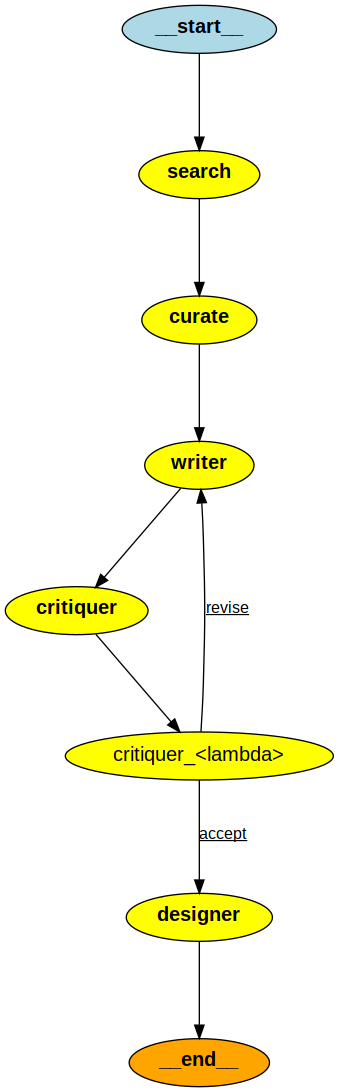

In [243]:
from IPython.display import Image
Image(runnable.get_graph().draw_png())

In [439]:
# query={'query':"How the europe could deal with rare materials for the next coming 20 years regarding its developement ?"}
# query={'query':"How Generative AI will affect businesses in the next 10 years ?"}
query={'query':"What is the future of data scientist regarding the emergence of cloud services and the availability of ready to use ML models ?"}
article_search = runnable.invoke(query)

--------------------
the search
--------------------
results retrieved
{'query': 'HWhat is the future of data scientist regarding the emergence of cloud services and the availability of ready to use ML models ?', 'topic': None, 'sources': [{'url': 'https://edtechmagazine.com/k12/article/2024/04/cosn2024-should-k-12-leaders-make-ai-education-mandatory-schools', 'published date': 'Fri, 12 Apr 2024 21:26:00 GMT', 'title': 'CoSN2024: Should K-12 Leaders Make AI Education Mandatory in Schools? - EdTech Magazine: Focus on K-12', 'content': 'While their approaches to artificial intelligence diverged somewhat during the closing session at CoSN2024 in Miami, the keynote speakers agreed that K–12 schools must prepare students for a future with AI. Hadi Partovi, founder of Code.org and Teach AI, and Mike Trucano, a visiting fellow in the Center for Universal Education at the Brookings Institution, shared a stage along with CoSN Board Chair Diane Doersch to discuss the power of AI to transform edu